In [10]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from statsmodels.stats.stattools import durbin_watson

In [41]:
df = pd.read_csv('data/train.csv')

In [42]:
df.tail()

# tail을 통해 total record 개수를 확인하고, 누락된 data가 있는지 확인

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
1014,1434,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA AUT3...,8950,71,10,1998,29000,Petrol,86,1,...,0,1,0,0,0,1,0,0,0,0
1015,1438,TOYOTA Corolla 1.3 16V HATCHB G6 2/3-Doors,7500,69,12,1998,20544,Petrol,86,1,...,1,1,0,1,1,1,0,0,0,0
1016,1440,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,8500,71,10,1998,17016,Petrol,86,0,...,0,1,0,0,0,1,0,0,0,0
1017,1441,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,7250,70,11,1998,16916,Petrol,86,1,...,0,0,0,0,0,1,0,0,0,0
1018,1442,TOYOTA Corolla 1.6 LB LINEA TERRA 4/5-Doors,6950,76,5,1998,1,Petrol,110,0,...,0,1,0,0,0,0,0,0,0,0


In [53]:
df.columns

Index([u'Id', u'Model', u'Price', u'Age_08_04', u'Mfg_Month', u'Mfg_Year',
       u'KM', u'Fuel_Type', u'HP', u'Met_Color', u'Color', u'Automatic', u'CC',
       u'Doors', u'Cylinders', u'Gears', u'Quarterly_Tax', u'Weight',
       u'Mfr_Guarantee', u'BOVAG_Guarantee', u'Guarantee_Period', u'ABS',
       u'Airbag_1', u'Airbag_2', u'Airco', u'Automatic_airco',
       u'Boardcomputer', u'CD_Player', u'Central_Lock', u'Powered_Windows',
       u'Power_Steering', u'Radio', u'Mistlamps', u'Sport_Model',
       u'Backseat_Divider', u'Metallic_Rim', u'Radio_cassette',
       u'Parking_Assistant', u'Tow_Bar'],
      dtype='object')

해당 train set은 1018개의 record가 있으며, 39개의 column으로 이루어져 있다.<br>
이 중, Price에 대한 회귀분석을 진행할 것이며, Price와 Id를 제외한 column 37개의 영향을 파악하고자 한다.

# 변수탐색
* 변수의 특성을 파악하고자 한다

### Model
* 보통 중고차의 경우, 본인이 원하는 차종을 선택하고, 그 차종에 따른 가격차가 굉장히 크다.
* 하지만 본 회귀분석은 도요타사의 코롤라(Corolla) 차종만을 분석하므로 큰 의미가 없을 수 있다,
* 다만, 같은 차종이라도 트림에 따른 가격가 발생하므로, 트림을 대표하는 모델명도 확인해야 할 필요가 있다고 판단된다
* 질적변수

In [59]:
df['Model'].value_counts()

TOYOTA Corolla 1.6 16V HATCHB LINEA TERRA 2/3-Doors           78
TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-Doors           57
TOYOTA Corolla 1.6 16V LIFTB LINEA LUNA 4/5-Doors             55
TOYOTA Corolla 1.6 16V LIFTB LINEA TERRA 4/5-Doors            52
TOYOTA Corolla 1.6 16V SEDAN LINEA TERRA 4/5-Doors            29
TOYOTA Corolla 1.3 16V LIFTB LINEA TERRA 4/5-Doors            28
TOYOTA Corolla 1.4 16V VVT I HATCHB TERRA 2/3-Doors           23
TOYOTA Corolla 1.6 16V VVT I LIFTB TERRA 4/5-Doors            23
TOYOTA Corolla 1.6 16V WAGON LINEA TERRA Stationwagen         22
TOYOTA Corolla 1.6 16V VVT I LIFTB SOL 4/5-Doors              19
TOYOTA Corolla 2.0 DSL HATCHB LINEA TERRA 2/3-Doors           18
TOYOTA Corolla 1.6 16V HATCHB LINEA LUNA 2/3-Doors            18
TOYOTA Corolla 1.6 16V VVT I 5DR SOL 4/5-Doors                15
TOYOTA Corolla 2.0 DSL LIFTB LINEA TERRA 4/5-Doors            15
TOYOTA Corolla 1.6 16V VVT I LIFTB LUNA 4/5-Doors             13
TOYOTA Corolla 1.6 16V VV

* 코롤라에도 연식과 배기량 등에 따른 다양한 트림이 존재하는 것으로 확인되었다.
* 다만, 1대만 있는 모델이 있는 등 모델 분류과정에 오타로 인한 실수가 있을 것으로 보인다.

### Price
* 본 회귀분석을 통해 예측하고자 하는 종속변수로, 중고차 가격을 의미한다
* 양적변수

In [60]:
df['Price'].describe()

count     1019.000000
mean     10738.358194
std       3614.987568
min       4350.000000
25%       8400.000000
50%       9850.000000
75%      11950.000000
max      31000.000000
Name: Price, dtype: float64

### Age_08_04
* 본 자료가 만들어진 2004년 8월 기준의 자동차 개월수를 의미한다
* 값이 클 수록 오래된 자동차임을 의미하며, 가격이 낮아질 것으로 예상된다.
* 양적변수

In [61]:
df['Age_08_04'].describe()

count    1019.000000
mean       56.041217
std        18.615283
min         1.000000
25%        44.000000
50%        61.000000
75%        70.000000
max        80.000000
Name: Age_08_04, dtype: float64

* 값이 1인 개체가 이상값인지 확인이 필요하다.

### Mfg_Month
* 자동차의 제조월을 의미한다.
* 중고차의 경우, 제조년을 기준으로 하는 경우가 많아 큰 영향이 없을 것으로 보인다.
* 1~12의 값을 순회하므로 양적변수라고 보기는 어렵다.
* 질적변수

In [58]:
df['Mfg_Month'].value_counts()

1     150
4     105
3     100
2      94
7      93
8      89
6      89
5      88
10     76
9      49
12     43
11     43
Name: Mfg_Month, dtype: int64

### Mfg_Year
* 자동차의 제조년을 의미한다.
* 중고차의 경우, 제조년을 기준으로 한 연식을 대표적으로 판단하게 되므로 Age_08_04와 함께 중요한 변수로 판단된다.
* 다만, Age_08_04와는 다중공선성이 클 것이므로, 두 변수를 따로 적용해보고 판단해야 할 것이다.
* 값이 커질수록 가격이 낮아지는 영향이 있을 것으로 보인다.
* 양적변수

In [63]:
df['Mfg_Year'].value_counts()

1999    316
1998    280
2000    155
2001    134
2003     60
2002     59
2004     15
Name: Mfg_Year, dtype: int64

#### Price에 대한 변수들의 상관관계 확인

In [27]:
corr_matrix = df.corr()
corr_matrix['Price'].sort_values(ascending=False)

Price                1.000000
Mfg_Year             0.893302
Boardcomputer        0.604629
Automatic_airco      0.595089
Weight               0.557015
CD_Player            0.493033
Airco                0.444310
Powered_Windows      0.363009
Central_Lock         0.361207
HP                   0.314898
ABS                  0.304380
Airbag_2             0.244497
Mistlamps            0.227719
Doors                0.180798
Quarterly_Tax        0.178874
Sport_Model          0.166143
Guarantee_Period     0.166141
Mfr_Guarantee        0.165026
Met_Color            0.152843
Metallic_Rim         0.136991
CC                   0.120415
Airbag_1             0.095595
Backseat_Divider     0.081085
Automatic            0.068063
Power_Steering       0.064949
Gears                0.053457
Parking_Assistant    0.044791
BOVAG_Guarantee      0.035516
Radio               -0.023749
Radio_cassette      -0.024527
Mfg_Month           -0.044255
Tow_Bar             -0.156850
KM                  -0.575962
Id        

* Mfg_Year, Boardcomputer, Automatic_Airco, Weight, KM, Age_08_04 등이 0.5 보다 큰 상관관계를 보이고 있음

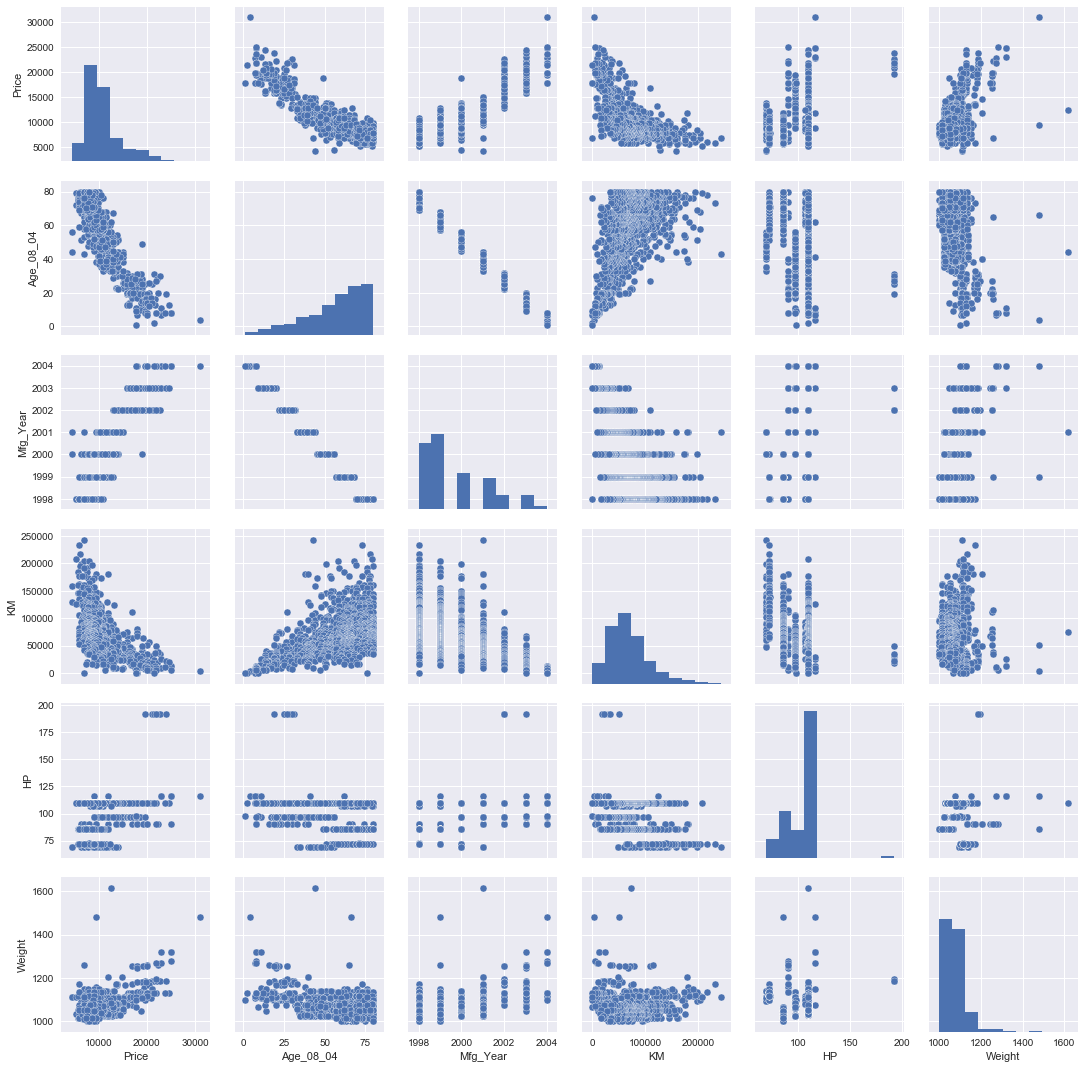

In [29]:
# 양적변수로 판단되는 변수들과 Price를 scatter plot으로 표현
# (Age_08_04, Mfg_Year, KM, HP, Weight)
# 상관관계가 있는지 plot을 통해 확인
import seaborn as sns
%matplotlib inline
sns.pairplot(pd.concat([dfy.Price, dfx[['Age_08_04', 'Mfg_Year', 'KM', 'HP', 'Weight']]], axis = 1))

* 상관도가 0.5 이상 나온 변수들은 그래프도 Price 값에 영향을 미칠 것으로 보인다.

#### Cat-val Boxplot

In [37]:
cols_cat = ['Mfg_Month', 'Fuel_Type', 'Met_Color', 'Color', 'Automatic',
            'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2',
            'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
            'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model',
            'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']

In [31]:
def display_multi_boxplots(start_feature_name, row, col):
    with plt.style.context(('seaborn-white')):
        f, axes = plt.subplots(row, col, figsize=(2.3*col, 3.5*row), sharey=True)

        nums = row*col
        start_idx = cols_cat.index(start_feature_name)

        for num, ax in zip(range(nums), axes.flat):
            try:
                sns.boxplot(x=dfx[cols_cat[start_idx + num]], y=dfy['Price'], palette="Set3", ax=ax)
            except:
                pass

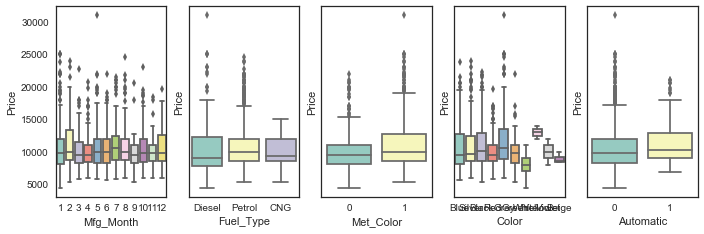

In [32]:
display_multi_boxplots('Mfg_Month', 1, 5)

* 상기 변수들은 가격에 큰 영향을 미치지 않을 것으로 보인다.

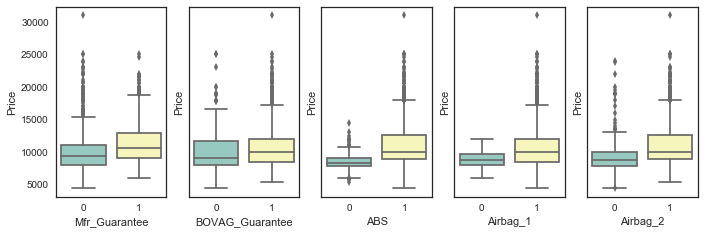

In [33]:
display_multi_boxplots('Mfr_Guarantee', 1, 5)

* ABS, Airbag_1, Airbag_2에서 가격의 차이가 있을 것으로 보인다

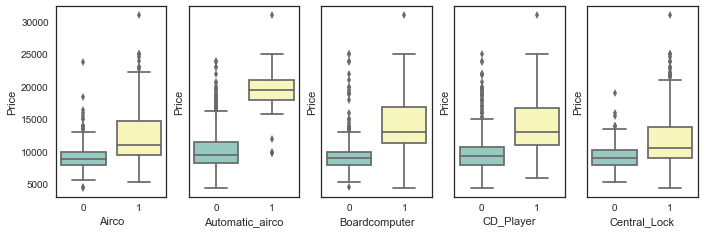

In [38]:
display_multi_boxplots('Airco', 1, 5)

* 상기 모든 변수가 가격과 상관이 있어보인다.
* 특히 Automatic_airco는 영향이 클 것으로 예상된다.

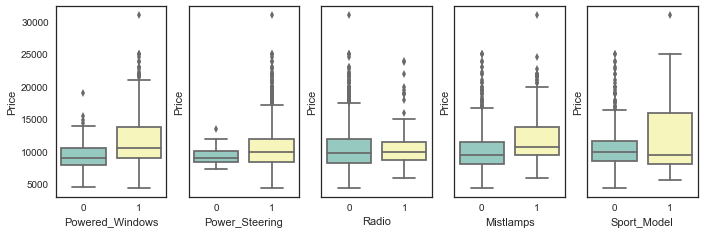

In [35]:
display_multi_boxplots('Powered_Windows', 1, 5)

* Powered_Windows, Power_Steering, Sport_Model이 가격과 상관이 있을 것으로 보인다.

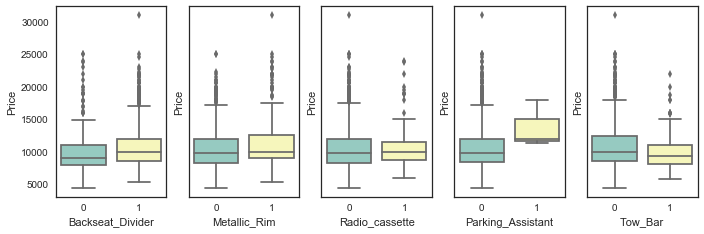

In [36]:
display_multi_boxplots('Backseat_Divider', 1, 5)

* 상기 변수들은 가격과 상관이 없을 것으로 보인다.